In [1]:
N_EPOCHS = 40
batch_size = 64
scan_type = 'T1CE'

## Setup

In [2]:
import os, random, time
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# Torchvision library
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from torchsummary import summary

from utilities import *

In [3]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
   device = torch.device('mps')
else:
    device = torch.device('cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

mps


In [4]:
def set_seed(seed, use_cuda = True, use_mps = False):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if use_mps:
        torch.mps.manual_seed(seed)

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available(), torch.backends.mps.is_available())

## Define Custom Dataset

In [5]:
class BraTSDataset(Dataset):
    def __init__(self, image_path = r'./BraTS/BraTS2021_Training_Data_2D', transform=None):
        'Initialisation'
        self.image_path = image_path
        self.folders_name = [folder for folder in os.listdir(self.image_path) if folder != '.DS_Store']
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.folders_name) * 155

    def __getitem__(self, index):
        'Generates one sample of data'

        # Determine the image index and the RGB layer
        image_idx = index // 155
        layer_idx = index % 155

        # Select sample
        file_name = self.folders_name[image_idx]
        
        path_img = os.path.join(self.image_path, file_name, scan_type.lower(), file_name + '_' + scan_type.lower() + '_' + str(layer_idx+1) + '.npy')
        image = np.load(path_img).astype(np.float32)

        path_label = os.path.join(self.image_path, file_name, 'seg', file_name + '_seg_' + str(layer_idx+1) + '.npy')
        label = np.load(path_label)
        
        if self.transform:
            image, label = self.transform([image, label])
        return image, label

In [6]:
class BinariseLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.sign(label)
        return image, new_label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample

        # numpy image: H x W x C
        # torch image: C x H x W
        # image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(label)

In [7]:
dataset = BraTSDataset(image_path = r'./BraTS/BraTS2021_Training_Data_2D',
                        transform=transforms.Compose([
                            BinariseLabel(),
                            ToTensor()
                        ]))

## Train Test Split

In [8]:
dataset_size = int(len(dataset)/155)
dataset_indices = list(range(dataset_size))

train_indices, test_indices = train_test_split(dataset_indices, test_size=0.1, random_state=SEED)
train_indices, val_indices = train_test_split(train_indices, test_size=0.22, random_state=SEED)

tmp_list = [[],[],[]]
for i, ind_list in enumerate([train_indices, val_indices, test_indices]):
    for ind in ind_list:
        for j in range(155):
            tmp_list[i].append(ind*155 + j)
train_indices, val_indices, test_indices = tmp_list

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Create the subset DataLoader
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
# multiprocessing_context="forkserver", persistent_workers=True, num_workers = 4

## Define Convlutional Autoencoder Structure

In [9]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      ## encoder layers ##
      # conv layer (depth from 1 --> 4), 3x3 kernels
      # Input 64 x 64
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding = 'same'), # 64 x 64
      nn.ReLU(),
      # pooling layer to reduce x-y dims by two; kernel and stride of 2
      nn.MaxPool2d(2), ## 32 x 32
      # conv layer (depth from 4 --> 8), 4x4 kernels
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding = 'same'), # 32 x 32
      nn.ReLU(),
      nn.MaxPool2d(2), # 16 x 16
      # conv layer (depth from 8 --> 12), 5x5 kernels
      nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding = 'same'), # ( 12 x ) 16 x 16
      nn.ReLU(),
      
      ## decoder layers ##
      # add transpose conv layers, with relu activation function
      nn.ConvTranspose2d(12, 6, kernel_size = 2, stride=2), # 32 x 32
      nn.ReLU(),
      nn.ConvTranspose2d(6, 1, kernel_size = 2, stride=2), # 64 x 64
      # output layer (with sigmoid for scaling from 0 to 1)
      # nn.Sigmoid()
    )
    
  def forward(self, x):
    x = x.view(int(np.prod(x.shape)/(64**2)), 1, 64, 64)
    x = self.features(x)
    # x = x.view(x.shape[0], -1)
    # x = torch.flatten(x, start_dim=1)
    return x

In [10]:
model = ConvAutoencoder().to(device)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 1,531 trainable parameters.


## Loss function and Optimisation Methods

In [11]:
# Loss
# criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
# criterion = nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

## Model Training

In [12]:
train_losses, train_accs, valid_losses, valid_accs,\
    train_losses_batch, train_accs_batch, valid_losses_batch, valid_accs_batch = model_training(N_EPOCHS,
                                                                                                    model,
                                                                                                    train_dataloader,
                                                                                                    val_dataloader,
                                                                                                    optimizer,
                                                                                                    criterion,
                                                                                                    device,
                                                                                                    './models/CA_' + scan_type + '.pt')

100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 1/10 -- Epoch Time: 135.26 s
Train -- Loss: 0.051, Acc: 98.06%
Val -- Loss: 0.043, Acc: 98.53%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 2/10 -- Epoch Time: 131.86 s
Train -- Loss: 0.041, Acc: 98.58%
Val -- Loss: 0.043, Acc: 98.53%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 3/10 -- Epoch Time: 133.21 s
Train -- Loss: 0.040, Acc: 98.60%
Val -- Loss: 0.044, Acc: 98.37%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 4/10 -- Epoch Time: 134.11 s
Train -- Loss: 0.040, Acc: 98.60%
Val -- Loss: 0.040, Acc: 98.58%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

-------

## Save train, val and test indices, losses and accuracies

In [13]:
os.makedirs('./results', exist_ok=True)

pd.DataFrame({
    'Train Loss': train_losses,
    'Train Acc': train_accs,
    'Valid Loss': valid_losses,
    'Valid Acc': valid_accs
}).to_csv(f'./results/CA_{scan_type}.csv', index = False)


In [23]:
stacked_df = pd.concat([pd.DataFrame(pd.DataFrame(train_losses_batch).values.flatten(), columns=['Train Loss']),
                        pd.DataFrame(pd.DataFrame(train_accs_batch).values.flatten(), columns=['Train Acc']),
                        pd.DataFrame(pd.DataFrame(valid_losses_batch).values.flatten(), columns=['Valid Loss']),
                        pd.DataFrame(pd.DataFrame(valid_accs_batch).values.flatten(), columns=['Valid Acc'])], axis=1)
stacked_df.to_csv(f'./results/CA_{scan_type}_batch.csv', index = False)

# Predict

In [13]:
test_loss, test_acc, test_batch_loss, test_batch_acc = model_testing(model, test_dataloader, criterion, device, model_name=f'./models/CA_{scan_type}.pt')

100.0 % loaded in this epoch for evaluation.

Test -- Loss: 0.040, Acc: 98.65 %


In [14]:
test_loss

0.03967314137594704

In [15]:
test_acc

0.986500372294507

In [28]:
stacked_df = pd.concat([pd.DataFrame(pd.DataFrame(test_batch_loss).values.flatten(), columns=['Test Loss']),
                        pd.DataFrame(pd.DataFrame(test_batch_acc).values.flatten(), columns=['Test Acc'])], axis=1)
stacked_df.to_csv(f'./results/CA_{scan_type}_batch_test.csv', index = False)

In [29]:
model.load_state_dict(torch.load(f'./models/CA_{scan_type}.pt'))
model.to(device)

ConvAutoencoder(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): ConvTranspose2d(12, 6, kernel_size=(2, 2), stride=(2, 2))
    (9): ReLU()
    (10): ConvTranspose2d(6, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [30]:
labels, preds = predict(model, test_dataloader, device)

In [31]:
preds[550]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [32]:
labels[550]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [33]:
folders = [folder for folder in os.listdir(os.path.join('./BraTS', 'BraTS2021_Training_Data')) if folder != '.DS_Store']

In [34]:
def index_converter(index):
    return index // 155, index % 155 # image_idx, layer_idx
index_converter(test_indices[550])

(831, 85)

In [35]:
folders[831]

'BraTS2021_00370'

In [36]:
np.load(f'./BraTS/BraTS2021_Training_Data_2D/BraTS2021_00370/seg/BraTS2021_00370_seg_86.npy')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

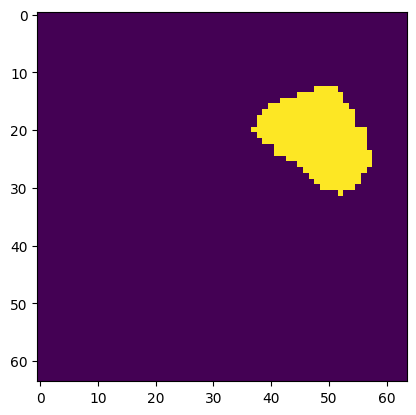

In [37]:
plt.imshow(preds[550])

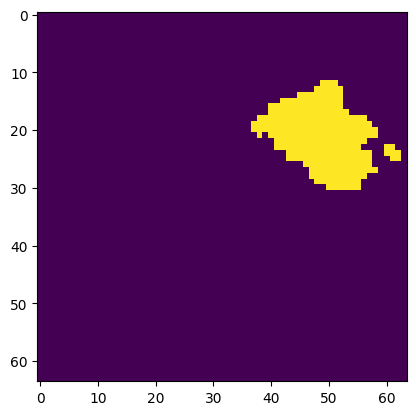

In [38]:
plt.imshow(labels[550])

In [70]:
tmp = preds[:10,:,:]
lmp = labels[:10,:,:]

In [71]:
print(tmp.shape, lmp.shape)

torch.Size([10, 64, 64]) torch.Size([10, 64, 64])


In [82]:
torch.mean(tmp.eq(lmp).sum(dim = (1,2))/ (64**2)).item()

0.9934326410293579

In [61]:
def dice_singular(pred, label):
    return torch.sum(pred * label).item() / np.prod(label.shape)

In [62]:
dice_singular(preds[550], labels[550])

0.055419921875

In [63]:
preds[550].eq(labels[550]).sum().item() / np.prod(labels[550].shape)

0.99072265625

In [66]:
# % of true positives which also are predicted as positives
torch.sum(preds[550] * labels[550]).item() / torch.sum(labels[550])

tensor(0.9008)

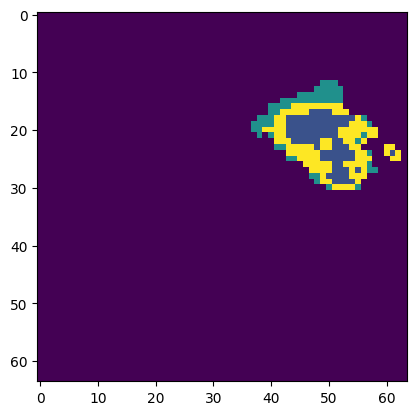

In [42]:
plt.imshow(np.load(f'./BraTS/BraTS2021_Training_Data_2D/BraTS2021_00370/seg/Brats2021_00370_seg_86.npy'))

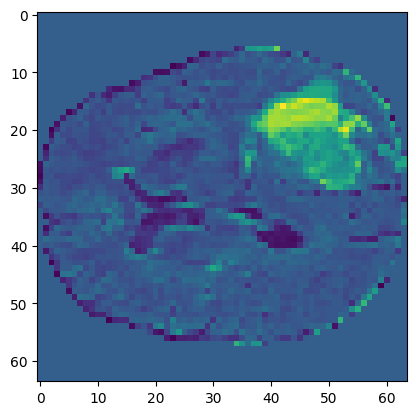

In [40]:
plt.imshow(np.load(f'./BraTS/BraTS2021_Training_Data_2D/BraTS2021_00370/flair/Brats2021_00370_flair_85.npy'))

In [47]:
print(labels.shape, preds.shape)

torch.Size([19530, 64, 64]) torch.Size([19530, 64, 64])


In [ ]:
test_indices # List to find image and layer id

In [24]:
def index_converter(index):
    return index // 155, index % 155 # image_idx, layer_idx

In [24]:
for i in range(10):
    image_idx, layer_idx = index_converter(test_indices[i])
    print(image_idx, layer_idx)
    print('BraTS2021_' + str(image_idx).zfill(5), 'BraTS2021_' + str(image_idx).zfill(5) + '_capred_' + str(layer_idx) + '.npy') # BraTS2021_00000_flair_1.npy
    # np.save(loc, np)

1200 0
BraTS2021_01200 BraTS2021_01200_capred_0
1200 1
BraTS2021_01200 BraTS2021_01200_capred_1
1200 2
BraTS2021_01200 BraTS2021_01200_capred_2
1200 3
BraTS2021_01200 BraTS2021_01200_capred_3
1200 4
BraTS2021_01200 BraTS2021_01200_capred_4
1200 5
BraTS2021_01200 BraTS2021_01200_capred_5
1200 6
BraTS2021_01200 BraTS2021_01200_capred_6
1200 7
BraTS2021_01200 BraTS2021_01200_capred_7
1200 8
BraTS2021_01200 BraTS2021_01200_capred_8
1200 9
BraTS2021_01200 BraTS2021_01200_capred_9


In [ ]:
os.makedirs('./BraTS/CA_Pred', exist_ok=True)

# CA_Pred
#  |__ Test Image 1
#       |__ Layer 1
#       |__ Layer 2
#  |__ Test Image 2
#       |__ Layer 1
#       |__ Layer 2

